In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

In [4]:
IMAGE_DIR = "Tire Textures/"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"normal": 0, "cracked": 1},
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",
                                        subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",
                                        subset = "validation", shuffle = True, **gen_args)

Found 563 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [5]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "testing_data",
                                                  shuffle = False,
                                                  **gen_args)

Found 325 images belonging to 2 classes.


In [6]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [7]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

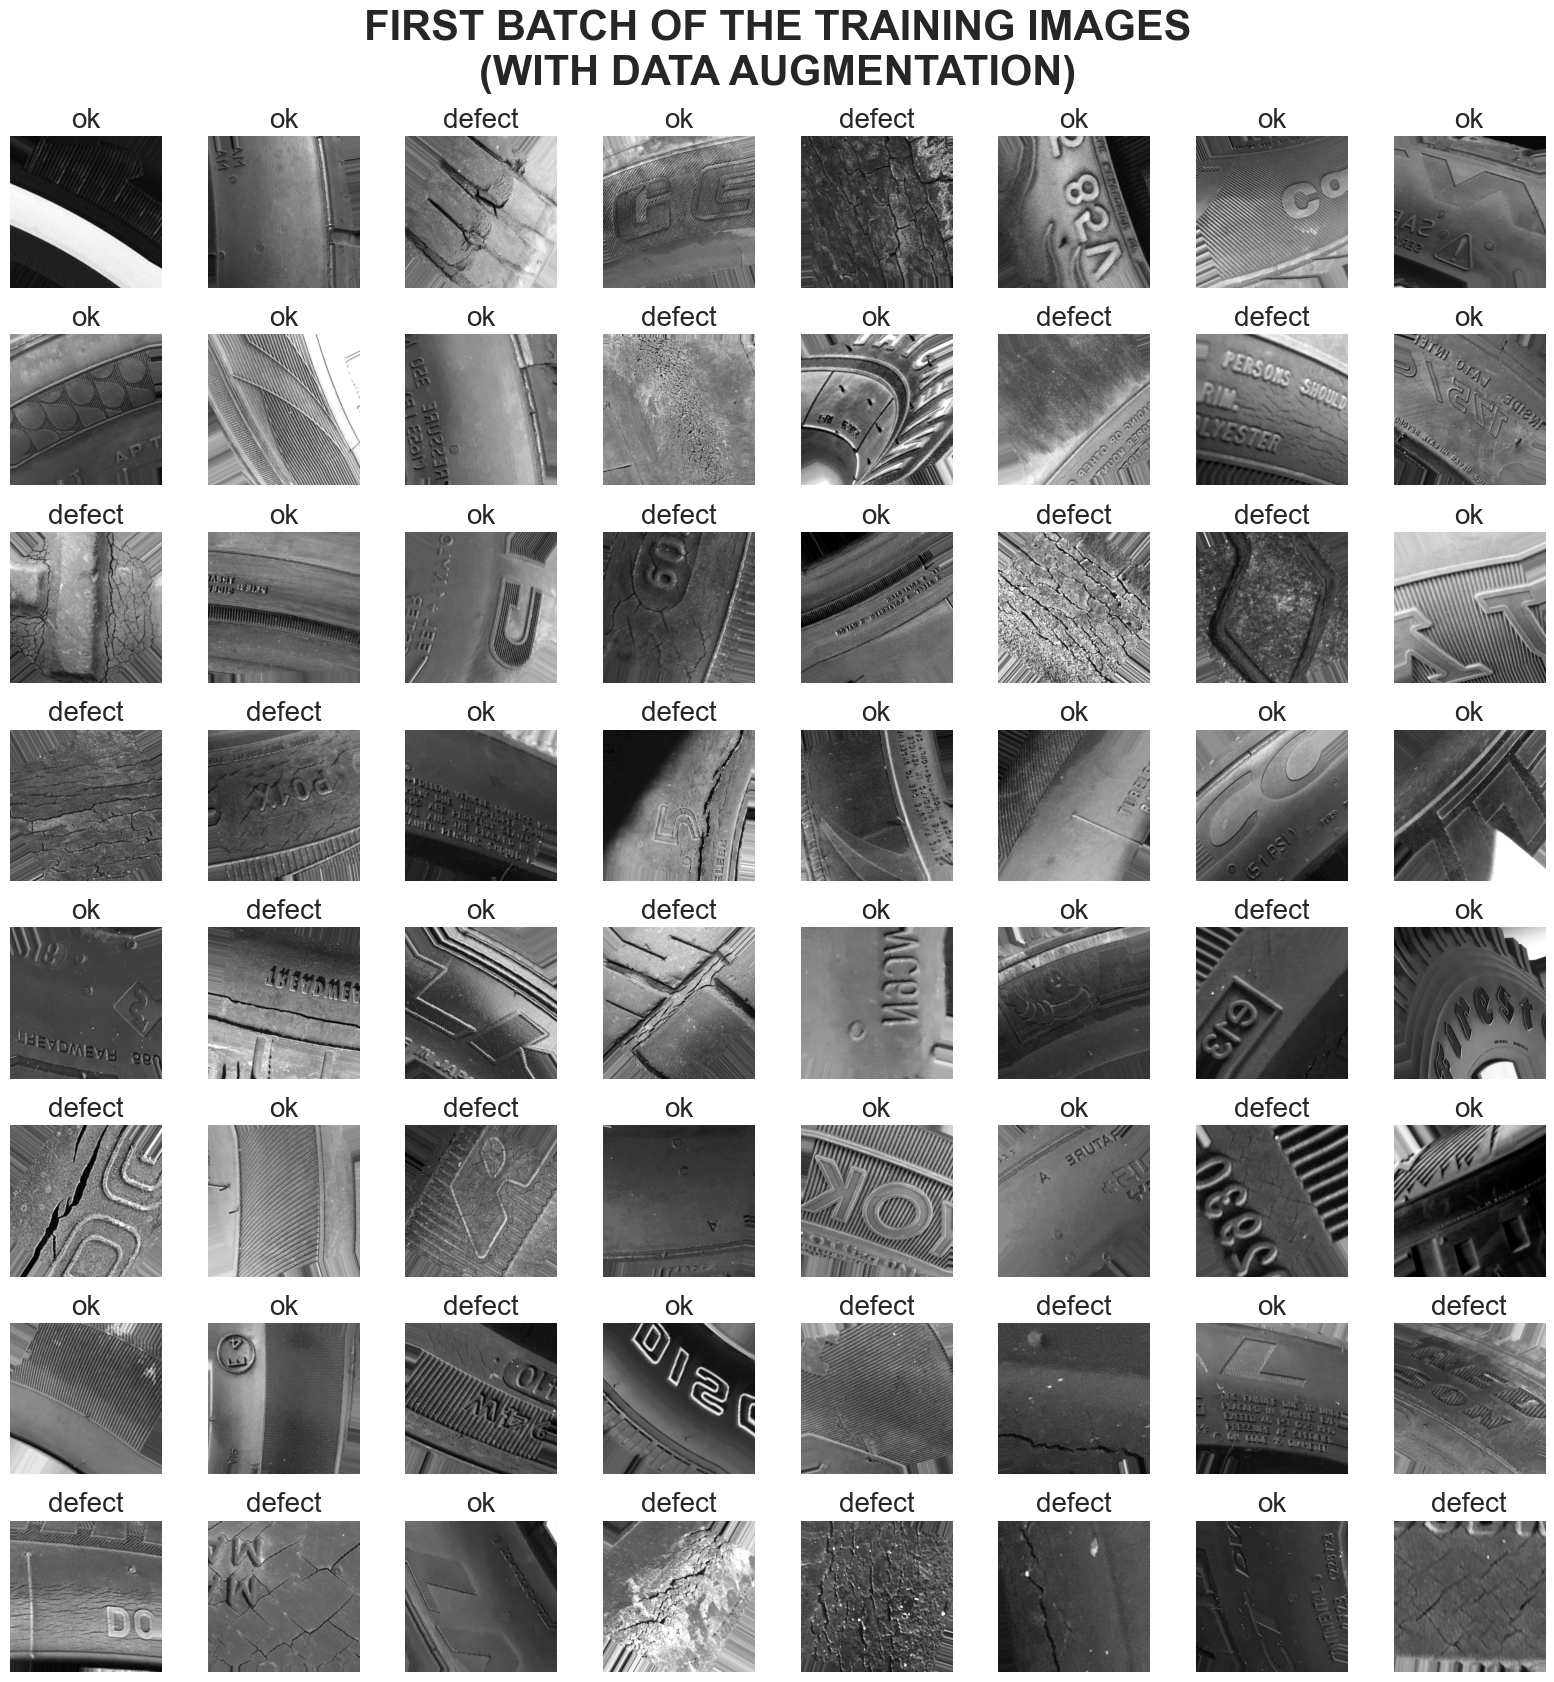

In [20]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

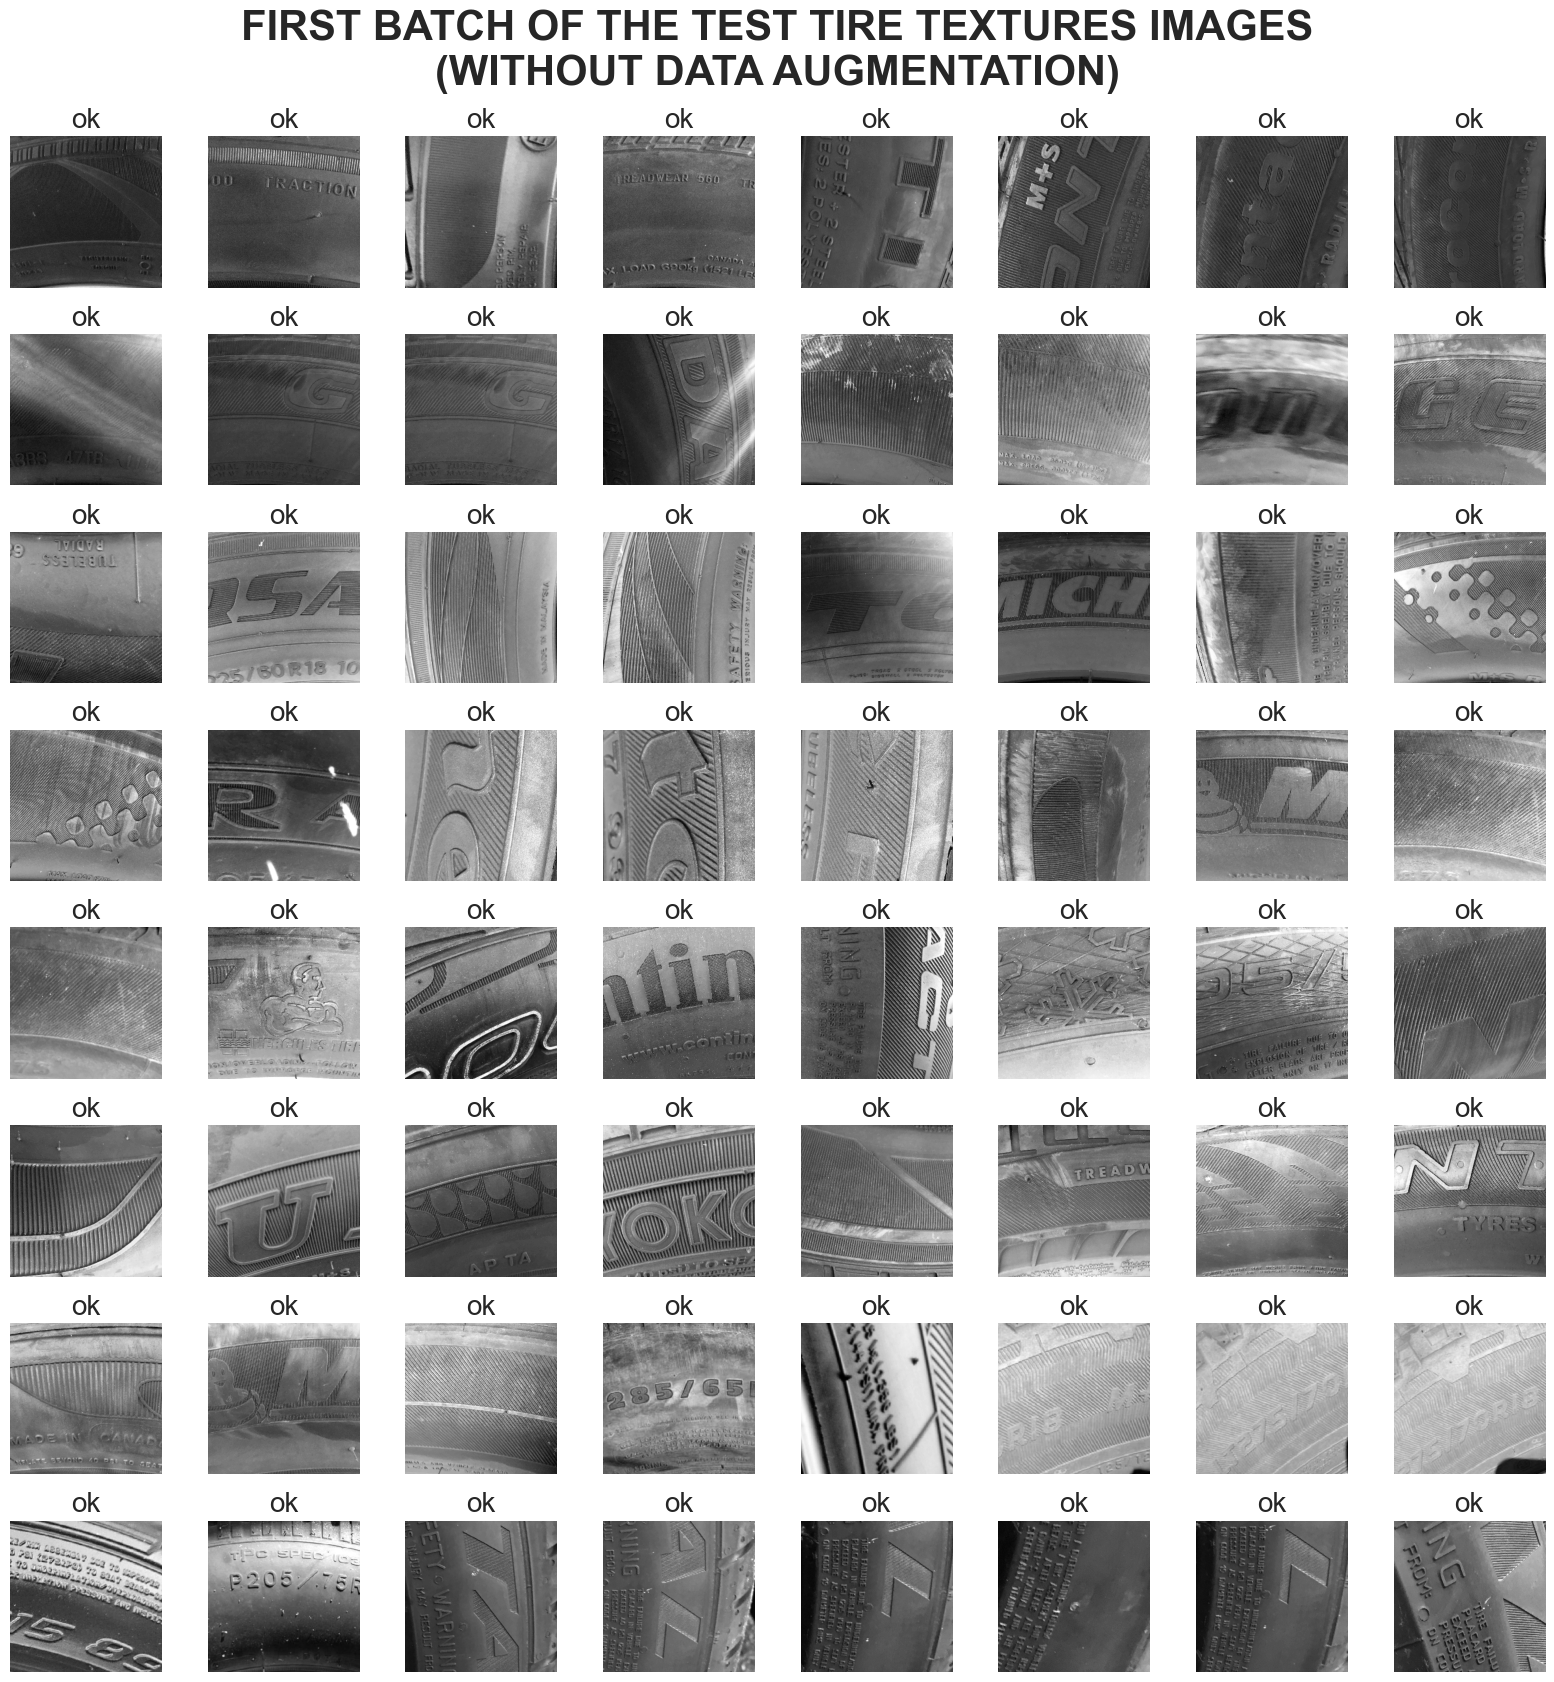

In [21]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST TIRE TEXTURES IMAGES\n(WITHOUT DATA AUGMENTATION)")

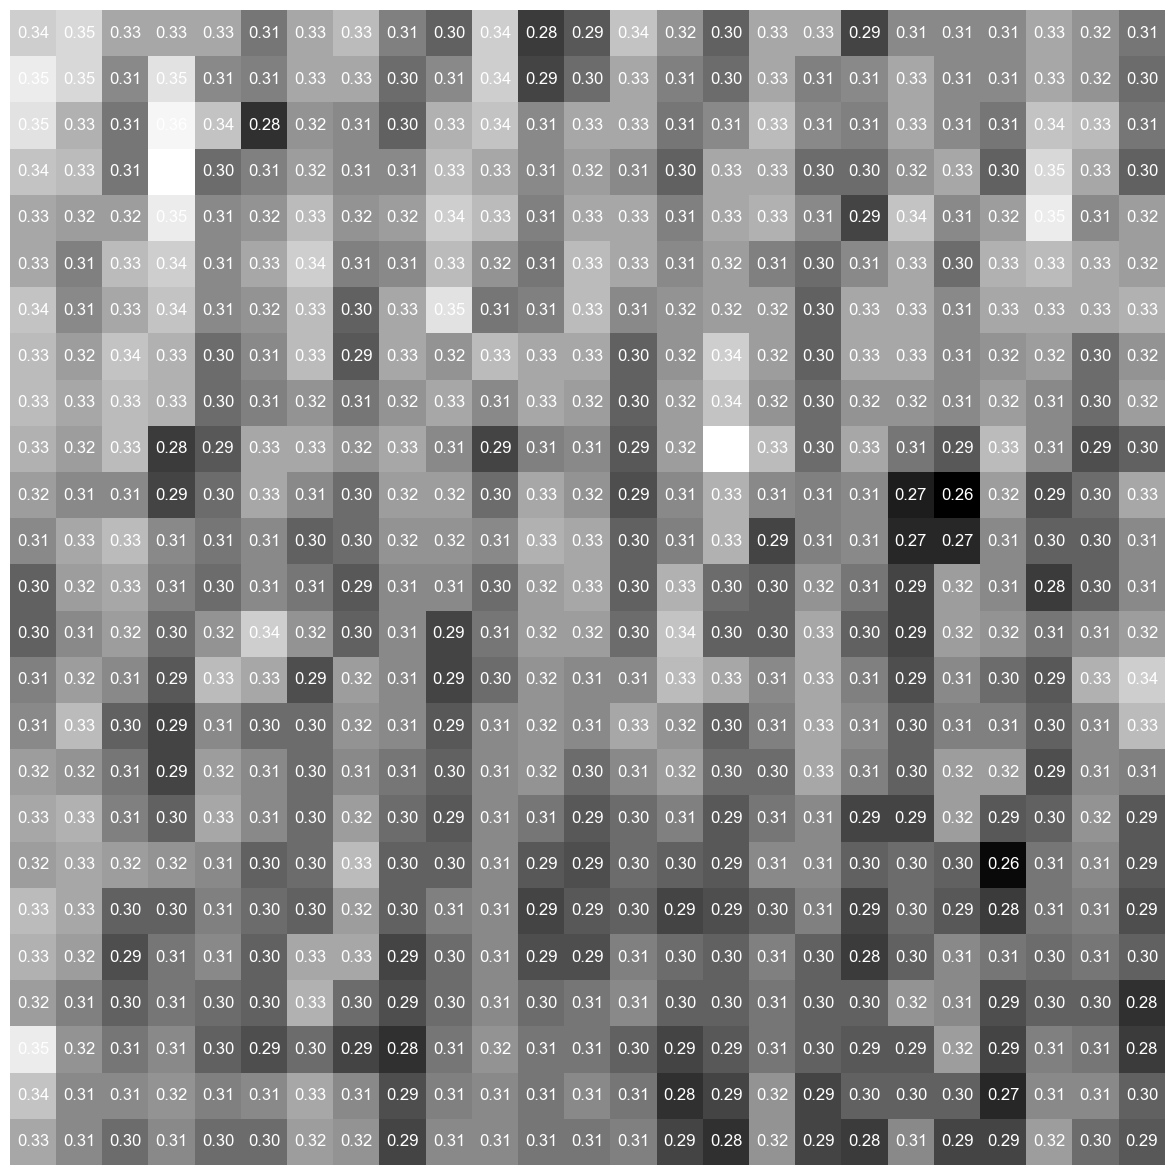

In [22]:
img = np.squeeze(train_images[7])[75:100, 75:100]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

In [8]:
model_cnn = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model_cnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 128)              

In [24]:
model_cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


In [25]:
checkpoint = ModelCheckpoint('model3.hdf5',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

model_cnn.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size = 32, 
                    epochs = 15,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/15


9/9 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.4778
Epoch 1: val_loss improved from inf to 0.69274, saving model to model3.hdf5
9/9 [==============================] - 26s 3s/step - loss: 0.6973 - accuracy: 0.4778 - val_loss: 0.6927 - val_accuracy: 0.5357
Epoch 2/15


c:\Users\dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5346
Epoch 2: val_loss did not improve from 0.69274
9/9 [==============================] - 23s 3s/step - loss: 0.6878 - accuracy: 0.5346 - val_loss: 0.6959 - val_accuracy: 0.4143
Epoch 3/15
9/9 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.5542
Epoch 3: val_loss did not improve from 0.69274
9/9 [==============================] - 23s 3s/step - loss: 0.6795 - accuracy: 0.5542 - val_loss: 0.7064 - val_accuracy: 0.4000
Epoch 4/15
9/9 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.6341
Epoch 4: val_loss did not improve from 0.69274
9/9 [==============================] - 22s 3s/step - loss: 0.6690 - accuracy: 0.6341 - val_loss: 0.7438 - val_accuracy: 0.4357
Epoch 5/15
9/9 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.6270
Epoch 5: val_loss did not improve from 0.69274
9/9 [==============================] - 22s 3s/step - loss: 0.6571 - accura

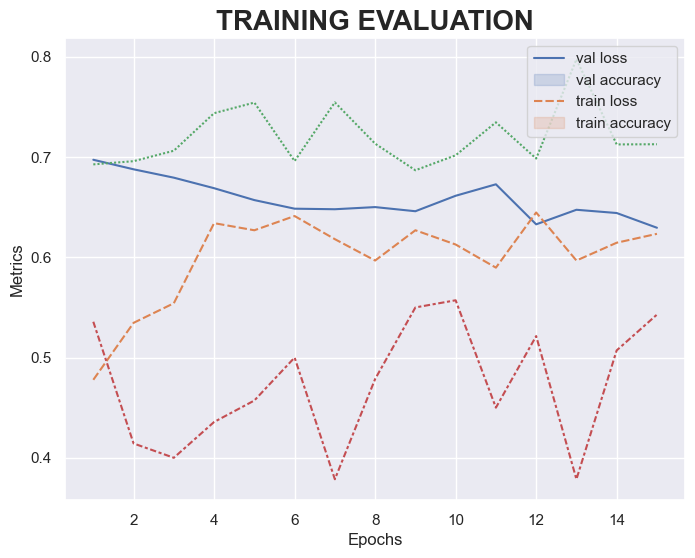

In [26]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_cnn.history.history,
                                 index = range(1, 1+len(model_cnn.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [9]:
best_model = load_model('model3.hdf5')

In [10]:
y_pred_prob = best_model.predict(test_dataset)

6/6 [==============================] - 28s 5s/step


In [16]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["Normal", "Cracked"]],
    columns = [["Predicted", "Predicted"], ["Normal", "Cracked"]],
)

Predicted        
                  Normal Cracked
Actual Normal         95      20
       Cracked       140      70

In [12]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.4043    0.8261    0.5429       115
           1     0.7778    0.3333    0.4667       210

    accuracy                         0.5077       325
   macro avg     0.5910    0.5797    0.5048       325
weighted avg     0.6456    0.5077    0.4936       325

